In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import math

In [2]:
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [3]:
thymio_data = []
Ts = 0.1

def motors(l_speed=500, r_speed=500):
    return {
        "motor.left.target": [l_speed],
        "motor.right.target": [r_speed],
    }

async def forward(motor_speed):
    await node.set_variables(motors(motor_speed,motor_speed))

async def rotate(theta, motor_speed): #theta is in radians
    direction_rot=(theta>=0)-(theta<0)
    await node.set_variables(motors(motor_speed*direction_rot, -motor_speed*direction_rot))
    # wait time to get theta 1.44 is the factor to correct
    time=(theta)*100/motor_speed*1.44
    await(client.sleep(time))
    # stop the robot
    await node.set_variables(motors(0, 0))

async def stop_motor():
    await node.set_variables(motors(0,0))

async def get_proximity_values():
    # Wait for the Thymio node
    node = await client.wait_for_node()
    # Wait for the proximity sensor variables
    await node.wait_for_variables({"prox.horizontal"})
    # Get the proximity values : v: Stands for "variables" and is used to access the cached variable values.
    proximity_values = node.v.prox.horizontal
    # Return the value of the front proximity sensor (index 2)
    return proximity_values[0:5]

## Parameters for local navigation
threshold_obst = 3500 
threshold_loc = 2500
local_motor_speed = 100
threshold_obst_list = [3200, 3600, 3600, 3600, 3200]

async def local_navigation():
    threshold_obst = 1000
    threshold_loc = 800
    local_motor_speed = 100
    threshold_obst_list = [3200, 3600, 3600, 3600, 3200]
    sens = await get_proximity_values()

    # Follow the obstacle by the left
    if (sens[0] + sens[1]) > (sens[4] + sens[3]):
        await bypass('right', sens, threshold_loc, local_motor_speed)

    # Follow the obstacle by the right    
    else:
        await bypass('left', sens, threshold_loc, local_motor_speed)

async def bypass(leftright, sens, threshold_loc, local_motor_speed):
    if leftright == "right":
        while sum(sens[i] > threshold_obst for i in range(0, 5)) > 0:
            print("Turn right")
            await rotate(np.pi/6/2, local_motor_speed)
            sens = await get_proximity_values()
            print(sens)

        while sens[0] > threshold_loc:
            await forward(local_motor_speed)
            sens = await get_proximity_values()
        
    elif leftright == "left":
        while sum(sens[i] > threshold_loc for i in range(0, 5)) > 0:
            print("Turn left")
            await rotate(-np.pi/6, local_motor_speed)
            sens = await get_proximity_values()

        while sens[4] > threshold_loc:
            await forward(local_motor_speed)
            sens = await get_proximity_values()

    if (leftright=="right" and sens[0] < threshold_loc):
        await forward(local_motor_speed)
        time.sleep(2)
        await rotate(-np.pi/4, 100)    

    await forward(local_motor_speed)
    await stop_motor()

def get_data():
    thymio_data.append({"sensor":node["prox.horizontal"],
                        "left_speed":node["motor.left.speed"],
                        "right_speed":node["motor.right.speed"]})

async def get_speed():
    await node.wait_for_variables() # wait for Thymio variables values
    rt = RepeatedTimer(Ts, get_data) # it auto-starts, no need of rt.start()

    try:
        await client.sleep(Ts)
    finally:
        rt.stop()
        node.send_set_variables(motors(0, 0))

def speed_estimation(left_speed, right_speed):
    real_thymio_speed = 33.5 #mm/s
    real_thymio_angular_speed = 0.73 #rad/s
    command_motor_for_calibration = 100

    #speed estimation
    speed_measured = (right_speed + left_speed)/2
    speed = (speed_measured * real_thymio_speed) / command_motor_for_calibration
    angular_speed_measured = (right_speed - left_speed)/2
    angular_speed = (angular_speed_measured * real_thymio_angular_speed) / command_motor_for_calibration

    return speed, angular_speed

# def real_speed(command_motor):
#     real_thymio_speed = 25.5 #mm/s
#     real_thymio_angular_speed = 0.38 #rad/s

#     speed_motor = (command_motor[0] * real_thymio_speed) / 50
#     angular_speed_motor = (command_motor[1] * real_thymio_angular_speed) / 50

#     return speed_motor, angular_speed_motor

def pos_estimation(speed, angular_speed, dt, previous_state_estimation):
    A = np.identity(3)
    B = np.array([[np.cos(previous_state_estimation[2]).item() * dt, 0, 0],
                  [np.sin(previous_state_estimation[2]).item() * dt, 0, 0],
                  [0, dt, 0]])
    input_vector = np.array([[speed], [angular_speed], [0]])
    state_estimation = np.dot(A, previous_state_estimation) + np.dot(B, input_vector)

    return state_estimation

def pos_estimation_bis(speed, angular_speed, dt, previous_state_estimation):
    A = np.identity(5)
    B = np.array([[np.cos(previous_state_estimation[2]).item() * dt, 0, 0],
                  [np.sin(previous_state_estimation[2]).item() * dt, 0, 0],
                  [0, dt, 0]])
    input_vector = np.array([[speed], [angular_speed], [0]])
    state_estimation = np.array([[np.dot(A, previous_state_estimation) + np.dot(B, input_vector)], [speed], [angular_speed]])

    return state_estimation

In [4]:
def kalman(speed, angular_speed, x_detected, x_est_prev, P_est_prev,detection, Ts):
   
   alpha = x_est_prev[3][0]
   qp = 0.04 # variance on position state in mm chosen arbitrarily: √qp = 0.2
   rp = 1 # variance on position measurement in mm
   A = np.array([[1, 0, Ts * np.cos(alpha), 0, 0],
                [0, 1, Ts * np.sin(alpha), 0, 0],
                [0,0,1,0,0],
                [0, 0, 0, 1, Ts],
                [0, 0, 0, 0, 1]])

   Q = np.eye(5)*qp

   x_est_a_priori = np.dot(A, x_est_prev) #+inc_alpha;
   x_est_a_priori[3] = x_est_a_priori[3]%(2*math.pi)

   P_est_a_priori = np.dot(A, np.dot(P_est_prev, A.T))
   P_est_a_priori = P_est_a_priori + Q if type(Q) != type(None) else P_est_a_priori

   if (detection):
       # transition detected
       pos_last_cam = x_detected
       y = np.array([[pos_last_cam[0]],[pos_last_cam[1]],[speed],[pos_last_cam[2]],[angular_speed]])
       H = np.eye(5)
       #R = np.array([[rp, 0],[0, r_nu]])
       R= np.eye(5)*rp #We don't have precise values yet
   else:
       # no transition, use only the speed
       y = np.array([[speed],[angular_speed]])
       H = np.array([[0., 0., 1., 0.,0.],[0., 0., 0., 0.,1.]])
       R = np.eye(2)*rp

   # innovation / measurement residual
   i = y - np.dot(H, x_est_a_priori)

   # measurement prediction covariance
   S = np.dot(H, np.dot(P_est_a_priori, H.T)) + R

   # Kalman gain (tells how much the predictions should be corrected based on the measurements)
   K = np.dot(P_est_a_priori, np.dot(H.T, np.linalg.inv(S)))

   # a posteriori estimate
   x_est = x_est_a_priori + np.dot(K,i)
   P_est = P_est_a_priori - np.dot(K,np.dot(H, P_est_a_priori))

   return x_est, P_est

In [19]:
def ex_kalman_filter(command_motor, speed, angular_speed, position_camera_history, previous_state_estimation, previous_covariance_estimation, dt,
                  HT=None, HNT=None, RT=None, RNT=None):
    """
    Estimates the current state using input sensor data and the previous state
    
    param command_motor: command sent to the motors
    param speed: measured speed (Thymio units)
    param angular_speed: measured angular speed (Thymio units)
    param position_camera_history: last position coordinates given by the camera
    param previous_state_estimation
    param previous_covariance_estimate: previous state a posteriori covariance
    param dt: time step
    
    return state_estimate: new a posteriori state estimation
    return P_estimate: new a posteriori state covariance (incertitude)
    """

    # qp = 0.04 # variance on position state in mm chosen arbitrarily: √qp = 0.2
    # rp = 1 # variance on position measurement in mm
    # Q = np.eye(3)*qp

    # Initialising the constants
    std_speed = 3 #8.77 #mm^2/s^2
    std_angular_speed = 0.05 #rad^2/s^2
    std_speed_motor = 16.5 #mm^2/s^2
    #Assuming that half og the varance is caused by the measurements and half is caused by perturbations to the states
    q_nu_motor = std_speed_motor / 2 # variance on angular state
    r_nu_translation = std_speed / 2 # variance on speed measurement
    r_nu_rotation = std_angular_speed / 2 # variance on angular speed measurement

    qp = 0.04 # variance on position state in mm chosen arbitrarily: √qp = 0.2
    qp_rot = 0.04 # variance on rotation state in rad chosen arbitrarily: √qp = 0.2
    rp = 1 # variance on position measurement in mm
    rp_angle = 0.02 # variance on angle measurement in rad
    #Q = np.array([[q_nu_motor, 0, 0], [0, q_nu_motor, 0], [0, 0, qp_rot]]) # process noise covariance matrix
    Q = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])

    if len(position_camera_history) > 1:
        last_position_camera, position_camera = position_camera_history[-2], position_camera_history[-1]
    else:
        last_position_camera, position_camera = None, None

    ## Prediciton through the a priori estimate
    #predicted_state_estimate = np.dot(A, previous_state_estimation) + np.dot(B, input_vector)
    #speed_motor, angular_speed_motor = real_speed(command_motor)
    speed_motor, angular_speed_motor = command_motor[0], command_motor[1]
    print("previous state", previous_state_estimation)
    print("actual", speed_motor, angular_speed_motor)
    print("measured", speed, angular_speed)
    predicted_state_estimation = pos_estimation(speed_motor, angular_speed_motor, dt, previous_state_estimation)
    predicted_state_estimation[2] = predicted_state_estimation[2] % (2 * math.pi) # normalize the angle between 0 and 2pi

    predicted_state_estimation_jacobian = np.array([[1 - angular_speed_motor * np.sin(previous_state_estimation[2]).item() * dt, 0, 0],
                                                    [angular_speed_motor * np.cos(previous_state_estimation[2]).item() * dt, 1, 0],
                                                    [0, 0, 1]])
    predicted_covariance_estimation = np.dot(predicted_state_estimation_jacobian, np.dot(previous_covariance_estimation, predicted_state_estimation_jacobian.T))
    predicted_covariance_estimation = predicted_covariance_estimation + Q if type(Q) != type(None) else predicted_covariance_estimation
    print("predicted_state_estimate", predicted_state_estimation)
    print("dt", dt)

    ## Update         
    if last_position_camera != position_camera and position_camera is not None:
        # camera position is available
        y = np.array([position_camera])
        H = np.identity(3)
        R = np.array([[r_nu_translation, 0, 0], [0, r_nu_translation, 0, 0], [0, 0, r_nu_rotation]])
    else:
        # no camera position, use only the speed measurement
        y = np.array(pos_estimation(speed, angular_speed, dt, previous_state_estimation))
        print("y", y)
        H = np.identity(3)
        R = np.array([[r_nu_translation, 0, 0], [0, r_nu_translation, 0], [0, 0, r_nu_rotation]])
        #R = np.eye(3)*rp

    # innovation / measurement residual
    i = y - np.dot(H, predicted_state_estimation)
    # measurement prediction covariance
    S = np.dot(H, np.dot(predicted_covariance_estimation, H.T)) + R
             
    # Kalman gain (tells how much the predictions should be corrected based on the measurements)
    K = np.dot(predicted_covariance_estimation, np.dot(H.T, np.linalg.inv(S)))
    
    # Updated state and covariance estimate
    state_estimate = predicted_state_estimation + np.dot(K, i)
    #P_estimate = previous_covariance_estimate - np.dot(K, np.dot(H, previous_covariance_estimate))
    P_estimate = np.dot((np.identity(3) - np.dot(K, H)), predicted_covariance_estimation)
     
    return state_estimate, P_estimate, predicted_state_estimation
    #return predicted_state_estimate, previous_covariance_estimate

In [20]:
def ex_kalman_filter_bis(speed, angular_speed, position_camera_history, previous_state_estimation, previous_covariance_estimation, dt,
                         HT=None, HNT=None, RT=None, RNT=None):
    """
    Estimates the current state using the speed sensor data, the camera position estimation and the previous state
    
    param speed [mm/s], angular_speed [rad/s]
    param position_camera_history: last position coordinates given by the camera
    param previous_state_estimation [x, y, theta, v, w]: previous state a posteriori estimation
    param dt: time step
    
    return state_estimation: new a posteriori state estimation
    return P_estimation: new a posteriori state covariance (incertitude)
    """

    # Initialising the constants
    std_speed = 3 #8.77 #mm^2/s^2
    std_angular_speed = 0.05 #rad^2/s^2

    #Assuming that half of the varance is caused by the measurements and half is caused by perturbations to the states
    r_nu_translation = std_speed / 2 # variance on speed measurement
    r_nu_rotation = std_angular_speed / 2 # variance on angular speed measurement

    qp = 0.04 # variance on position state in mm chosen arbitrarily: √qp = 0.2
    rp = 1 # variance on position measurement in mm
    rp_angle = 0.02 # variance on angle measurement in rad

    # Q = np.array([[?, 0, 0, 0, 0],
    #               [0, ?, 0, 0, 0],
    #               [0, 0, ?, 0, 0],
    #               [0, 0, 0, ?, 0],
    #               [0, 0, 0, 0, ?]]) # process noise covariance matrix MUST CHANGE
    Q = np.identity(5) * qp

    if len(position_camera_history) > 1:
        last_position_camera, position_camera = position_camera_history[-2], position_camera_history[-1]
    else: last_position_camera, position_camera = None, None

    A = np.array([[1, 0, dt * np.cos(previous_state_estimation[3]).item(), 0, 0],
                  [0, 1, dt * np.sin(previous_state_estimation[3]).item(), 0, 0],
                  [0, 0, 1, 0, 0],
                  [0, 0, 0, 1, dt],
                  [0, 0, 0, 0, 1]])

    ## Prediciton Step, through the previous estimation
    predicted_state_estimation = np.dot(A, previous_state_estimation)
    predicted_state_estimation[3] = predicted_state_estimation[3] % (2 * math.pi) # normalize the angle between 0 and 2pi

    predicted_state_estimation_jacobian = np.array([[1, 0, previous_state_estimation[4].item() * np.cos(previous_state_estimation[3]).item() * dt, 0, 0],
                                                  [0, 1, previous_state_estimation[4].item() * np.sin(previous_state_estimation[3]).item() * dt, 0, 0],
                                                  [0, 0, 1, 0, 0],
                                                  [0, 0, 0, 1, dt],
                                                  [0, 0, 0, 0, 1]])
    predicted_covariance_estimation = np.dot(predicted_state_estimation_jacobian,
                                             np.dot(previous_covariance_estimation, predicted_state_estimation_jacobian.T))
    if type(Q) != type(None): predicted_covariance_estimation = predicted_covariance_estimation + Q 
    else: predicted_covariance_estimation
    
    ## Update Step      
    if last_position_camera != position_camera and position_camera is not None:
        # camera position is available
        y = np.array([[position_camera[0:1]], [speed], [position_camera[2]], [angular_speed]])
        H = np.identity(5)
        R = np.array([[rp, 0, 0, 0, 0],
                      [0, rp, 0, 0, 0],
                      [0, 0, r_nu_translation, 0, 0],
                      [0, 0, 0, rp_angle, 0],
                      [0, 0, 0, 0, r_nu_rotation]]) # process noise covariance matrix
    else:
        # no transition, use only the speed
        y = np.array([[speed], [angular_speed]])
        H = np.array([[0, 0, 1, 0, 0], [0, 0, 0, 0, 1]])
        R = np.array([[r_nu_translation, 0], [0, r_nu_rotation]]) # process noise covariance matrix

    # innovation / measurement residual
    i = y - np.dot(H, predicted_state_estimation)
    # measurement prediction covariance
    S = np.dot(H, np.dot(predicted_covariance_estimation, H.T)) + R
             
    # Kalman gain (tells how much the predictions should be corrected based on the measurements)
    K = np.dot(predicted_covariance_estimation, np.dot(H.T, np.linalg.inv(S)))
    
    # Updated state and covariance estimate
    state_estimation = predicted_state_estimation + np.dot(K, i)
    #P_estimate = previous_covariance_estimate - np.dot(K, np.dot(H, previous_covariance_estimate))
    P_estimation = np.dot((np.identity(5) - np.dot(K, H)), predicted_covariance_estimation)
     
    return state_estimation, P_estimation

In [21]:
async def get_position(state_estimate_bis, P_estimate_bis, state_estimate, P_estimate, state_estimate_ex, P_estimate_ex, command_motor, start_time):

    await get_speed()
    left_speed = node["motor.left.speed"]
    right_speed = node["motor.right.speed"]
    dt = time.time() - start_time 
    speed, angular_speed = speed_estimation(left_speed, right_speed)
    command_motor = speed_estimation(command_motor[0], command_motor[1])

    camera_position_histoty = []
    camera_position = [np.array([[0], [0], [0]])] #get_camera_position()
    camera_position_histoty.append(camera_position)
    camera_position = [np.array([[0], [0], [0]])] #get_camera_position()
    
    new_state_estimate_ex, new_P_estimate_ex, pos_motor = ex_kalman_filter(command_motor, speed, angular_speed, camera_position_histoty, state_estimate_ex[-1], P_estimate_ex[-1], dt)
    new_state_estimate, new_P_estimate = kalman(speed, angular_speed,camera_position,state_estimate[-1],P_estimate[-1],False,0.1)
    new_state_estimate_bis, new_P_estimate_bis = ex_kalman_filter_bis(speed, angular_speed, camera_position_histoty, state_estimate_bis[-1], P_estimate_bis[-1], dt)
    state_estimate_ex.append(new_state_estimate_ex)
    P_estimate_ex.append(new_P_estimate_ex)
    state_estimate.append(new_state_estimate)
    P_estimate.append(new_P_estimate)
    state_estimate_bis.append(new_state_estimate_bis)
    P_estimate_bis.append(new_P_estimate_bis)
    start_time = time.time()

    return state_estimate_bis, P_estimate_bis, state_estimate, P_estimate, state_estimate_ex, P_estimate_ex, speed, angular_speed, start_time, command_motor

In [22]:
#MAIN CODE : 

local_obstacle = False
command_motor_forward = [100, 100]
command_motor_rotate = [-100, 100]
speed_history = []
angular_speed_history = []
camera_position_histoty = []
speed_motor_histoty = []
angular_speed_motor_histoty = []
norm = []
norm_ex = []
norm_motor = []
norm_ex_bis = []
angle = []
angle_ex = []
angle_ex_bis = []
thymio_data.clear()

async def main():

    global local_obstacle
    state_estimate = [np.array([[0], [0], [0], [0], [0]])]
    P_estimate = [1000 * np.ones(5)]
    state_estimate_bis = [np.array([[0], [0], [0], [0], [0]])]
    P_estimate_bis = [1000 * np.ones(5)]
    state_estimate_ex = [np.array([[0], [0], [0]])]
    P_estimate_ex = [1000 * np.ones(3)]
    start_time = time.time()
    start = time.time()
    print("start", start)

    while(1):
        sens = await get_proximity_values()
        if (sum(sens[i] > threshold_obst for i in range(0, 5)) > 0):
            local_obstacle = True

        if(local_obstacle):
            break

        if not local_obstacle: 
            #node.send_set_variables(motors(command_motor_forward[0], command_motor_forward[1]))
            node.send_set_variables(motors(command_motor_rotate[0], command_motor_rotate[1]))
            state_estimate_bis, P_estimate_bis, state_estimate, P_estimate, state_estimate_ex, P_estimate_ex, speed, angular_speed, start_time, speed_motor = await get_position(state_estimate_bis, P_estimate_bis, state_estimate, P_estimate, state_estimate_ex, P_estimate_ex, command_motor_forward, start_time)
            speed_history.append(speed)
            angular_speed_history.append(angular_speed)
            speed_motor_histoty.append(speed_motor[0])
            angular_speed_motor_histoty.append(speed_motor[1])
            #print(state_estimate[-1][0]/10, state_estimate[-1][1]/10, (state_estimate[-1][3]*180)/np.pi)
            print("state_estimate", state_estimate[-1])
            norm_ex.append(np.sqrt(state_estimate_ex[-1][0]**2 + state_estimate_ex[-1][1]**2))
            norm.append(np.sqrt(state_estimate[-1][0]**2 + state_estimate[-1][1]**2))
            norm_ex_bis.append(np.sqrt(state_estimate_bis[-1][0]**2 + state_estimate_bis[-1][1]**2))
            angle_ex.append((state_estimate_ex[-1][2]*180)/np.pi)
            angle.append((state_estimate[-1][3]*180)/np.pi)
            angle_ex_bis.append((state_estimate_bis[-1][2]*180)/np.pi)
            print("norm", norm[-1])
            print("temps", time.time() - start)

await main()

start 1701691144.370071
previous state [[0]
 [0]
 [0]]
actual 33.5 0.0
measured 0.0 0.0
predicted_state_estimate [[53.49126148]
 [ 0.        ]
 [ 0.        ]]
dt 1.5967540740966797
y [[0.]
 [0.]
 [0.]]
state_estimate [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
norm [0.]
temps 1.6012072563171387
previous state [[52.62852007]
 [-0.86274141]
 [-0.86274141]]
actual 33.5 0.0
measured 1.005 0.0584
predicted_state_estimate [[54.99552359]
 [-3.62744081]
 [ 5.4204439 ]]
dt 0.1086430549621582
y [[52.69953018]
 [-0.94568239]
 [-0.85639665]]
state_estimate [[0.28831065]
 [0.26056562]
 [0.30543298]
 [0.28493476]
 [0.23656479]]
norm [0.38860967]
temps 1.7106270790100098
previous state [[51.96149038]
 [-6.66147402]
 [ 2.38641069]]
actual 33.5 0.0
measured 0.8375 0.52195
predicted_state_estimate [[49.39333018]
 [-4.24400639]
 [ 2.38641069]]
dt 0.10528302192687988
y [[51.89728638]
 [-6.60103733]
 [ 2.44136316]]
state_estimate [[0.47387072]
 [0.40240931]
 [0.46290892]
 [0.4630106 ]
 [0.36904493]]
norm [0.62168056]
t

In [11]:
std_speed = np.std(speed_history[30:])
std_angular_speed = np.std(angular_speed_history[30:])
std_command_motor = np.std(speed_motor_histoty[30:])
std_angular_speed_motor = np.std(angular_speed_motor_histoty[30:])
print("The speed variance in mm^2/s^2 is {}".format(std_speed))
print("The angular speed variance in rad^2/s^2 is {}".format(std_angular_speed))
print("The command motor variance in mm^2/s^2 is {}".format(std_command_motor))
print("The angular speed motor variance in rad^2/s^2 is {}".format(std_angular_speed_motor))
print(len(speed_history))

The speed variance in mm^2/s^2 is 2.019081113493989
The angular speed variance in rad^2/s^2 is 0.07595842468016531
The command motor variance in mm^2/s^2 is 0.0
The angular speed motor variance in rad^2/s^2 is 0.0
81


In [9]:
await node.set_variables(motors(0, 0))

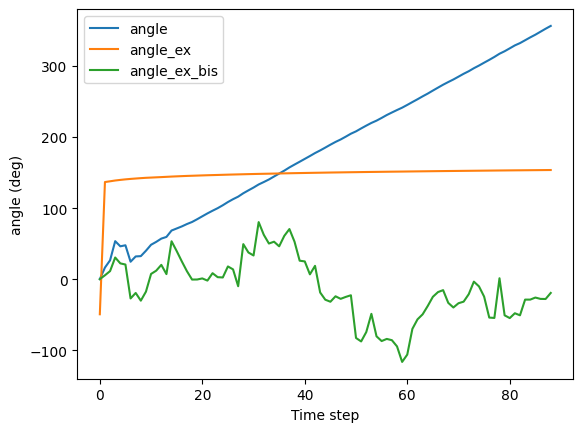

In [23]:
plt.plot(angle[:], label="angle")
plt.plot(angle_ex[:], label="angle_ex")
plt.plot(angle_ex_bis[:], label="angle_ex_bis")
plt.xlabel("Time step")
plt.ylabel("angle (deg)")
plt.legend()

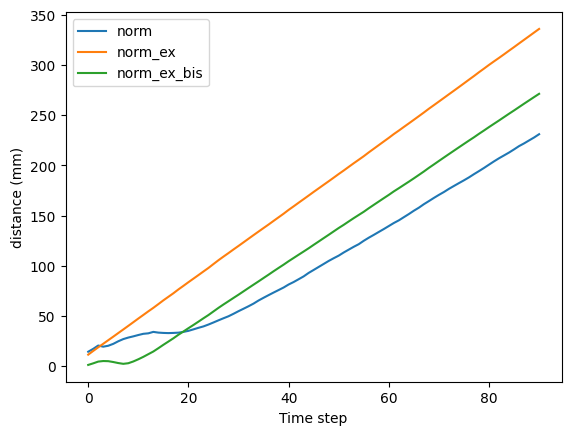

In [41]:
plt.plot(norm[:], label="norm")
plt.plot(norm_ex[:], label="norm_ex")
plt.plot(norm_ex_bis[:], label="norm_ex_bis")
plt.xlabel("Time step")
plt.ylabel("distance (mm)")
plt.legend()

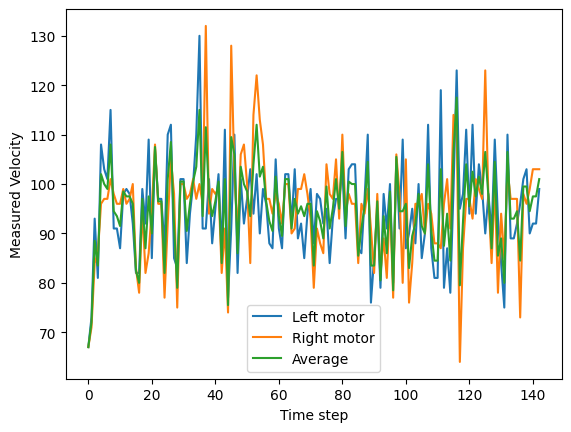

In [21]:
l_speed = [x["left_speed"] for x in thymio_data]
r_speed = [x["right_speed"] for x in thymio_data]
avg_speed = [(x["left_speed"]+x["right_speed"])/2 for x in thymio_data]
plt.plot(l_speed, label="Left motor")
plt.plot(r_speed, label="Right motor")
plt.plot(avg_speed, label="Average")
plt.xlabel("Time step")
plt.ylabel("Measured Velocity")
plt.legend()

In [85]:
await node.set_variables(motors(101, 100))
await client.sleep(10)
await node.set_variables(motors(0, 0))

In [84]:
await node.set_variables(motors(0, 0))

In [87]:
await node.set_variables(motors(-101, 100))
await client.sleep(10)
await node.set_variables(motors(0, 0))